### Simple Language Modeling (based on Andrej Karpathy Youtube tutorials)

The dataset is a large collection of people's first names. We will train character level language models on next character prediction task and use it to generate new names.

In [3]:
# load dataset and store the words in a list
words = open('names.txt', 'r').read().split()

In [6]:
print(f"Total number of words: {len(words)}")
print(f"Shortest word: {min([len(w) for w in words])}")
print(f"Longest word: {max([len(w) for w in words])}")

Total number of words: 32033
Shortest word: 2
Longest word: 15


### Bi-Gram Language Model. 

This model predicts the next character given the previous two characters in a sequence, i.e. the conditional probability distribution $p(c2 | c1)$ for a sequence {c1,c2} where c1 is known/given. It calculates this probability distribution as follows:

$p(c2|c1) = \frac{\text{count}(c1, c2)}{\text{count}(c1)}$ 

where $count(c1,c2)$ is the number of times the sequence {c1,c2} has been observed in the corpus. Similarly $count(c1)$ is the number of times the sequence {c1} has been observed.



In [64]:
# first lets count all possible bigrams and unigrams in the corpus
unigrams = {}
bigrams = {}
special_token = '*'  # this special token will be used as the start and end of each word  
for w in words:
    # wrap the word with start and end special characters
    chars = [special_token] + list(w) + [special_token]

    # count unigrams
    for c in chars:
        unigrams[c] = unigrams.get(c, 0) + 1

    # count bigrams
    for c1, c2 in zip(chars, chars[1:]):
        bigram = (c1,c2)
        bigrams[bigram] = bigrams.get(bigram, 0) + 1    
        


In [65]:
# sort the dictionary item tuples by value
sorted(unigrams.items(), key = lambda key_value : key_value[1])

[('q', 272),
 ('x', 697),
 ('f', 905),
 ('w', 929),
 ('p', 1026),
 ('g', 1927),
 ('z', 2398),
 ('v', 2573),
 ('b', 2645),
 ('j', 2900),
 ('u', 3135),
 ('c', 3532),
 ('k', 5040),
 ('d', 5496),
 ('t', 5570),
 ('m', 6642),
 ('h', 7616),
 ('o', 7934),
 ('s', 8106),
 ('y', 9776),
 ('r', 12700),
 ('l', 13958),
 ('i', 17701),
 ('n', 18327),
 ('e', 20423),
 ('a', 33885),
 ('*', 64066)]

In [66]:
sorted(bigrams.items(), key = lambda key_value : key_value[1])

[(('q', 'r'), 1),
 (('d', 'z'), 1),
 (('p', 'j'), 1),
 (('q', 'l'), 1),
 (('p', 'f'), 1),
 (('q', 'e'), 1),
 (('b', 'c'), 1),
 (('c', 'd'), 1),
 (('m', 'f'), 1),
 (('p', 'n'), 1),
 (('w', 'b'), 1),
 (('p', 'c'), 1),
 (('h', 'p'), 1),
 (('f', 'h'), 1),
 (('b', 'j'), 1),
 (('f', 'g'), 1),
 (('z', 'g'), 1),
 (('c', 'p'), 1),
 (('p', 'k'), 1),
 (('p', 'm'), 1),
 (('x', 'n'), 1),
 (('s', 'q'), 1),
 (('k', 'f'), 1),
 (('m', 'k'), 1),
 (('x', 'h'), 1),
 (('g', 'f'), 1),
 (('v', 'b'), 1),
 (('j', 'p'), 1),
 (('g', 'z'), 1),
 (('v', 'd'), 1),
 (('d', 'b'), 1),
 (('v', 'h'), 1),
 (('h', 'h'), 1),
 (('g', 'v'), 1),
 (('d', 'q'), 1),
 (('x', 'b'), 1),
 (('w', 'z'), 1),
 (('h', 'q'), 1),
 (('j', 'b'), 1),
 (('x', 'm'), 1),
 (('w', 'g'), 1),
 (('t', 'b'), 1),
 (('z', 'x'), 1),
 (('p', 'b'), 2),
 (('t', 'g'), 2),
 (('q', 's'), 2),
 (('t', 'x'), 2),
 (('f', 'k'), 2),
 (('b', 't'), 2),
 (('j', 'n'), 2),
 (('k', 'c'), 2),
 (('z', 'k'), 2),
 (('s', 'j'), 2),
 (('s', 'f'), 2),
 (('z', 'j'), 2),
 (('n', 'q

In [67]:
import torch

In [68]:
# now lets create an indexed vocabulary of characters
vocab = sorted(set(unigrams.keys()))
ctoi = {vocab[i]:i for i in range(len(vocab))}
itoc = {i:vocab[i] for i in range(len(vocab))}
print(f"Vocabulary: {vocab}")
print(f"Character indices: {ctoi}")


Vocabulary: ['*', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Character indices: {'*': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [69]:
# instead of storing the counts in a dictionary, lets put them in pytorch tensors
ug_counts = torch.zeros(len(vocab), dtype=torch.int32)
bg_counts = torch.zeros((len(vocab),len(vocab)), dtype=torch.int32)

for w in words:
    # wrap the word with start and end special characters
    chars = [special_token] + list(w) + [special_token]

    # count unigrams
    for c in chars:
        ix = ctoi[c]
        ug_counts[ix] += 1

    # count bigrams
    for c1, c2 in zip(chars, chars[1:]):
        bigram = (c1,c2)
        ix1, ix2 = ctoi[c1], ctoi[c2]  
        bg_counts[ix1, ix2] += 1  


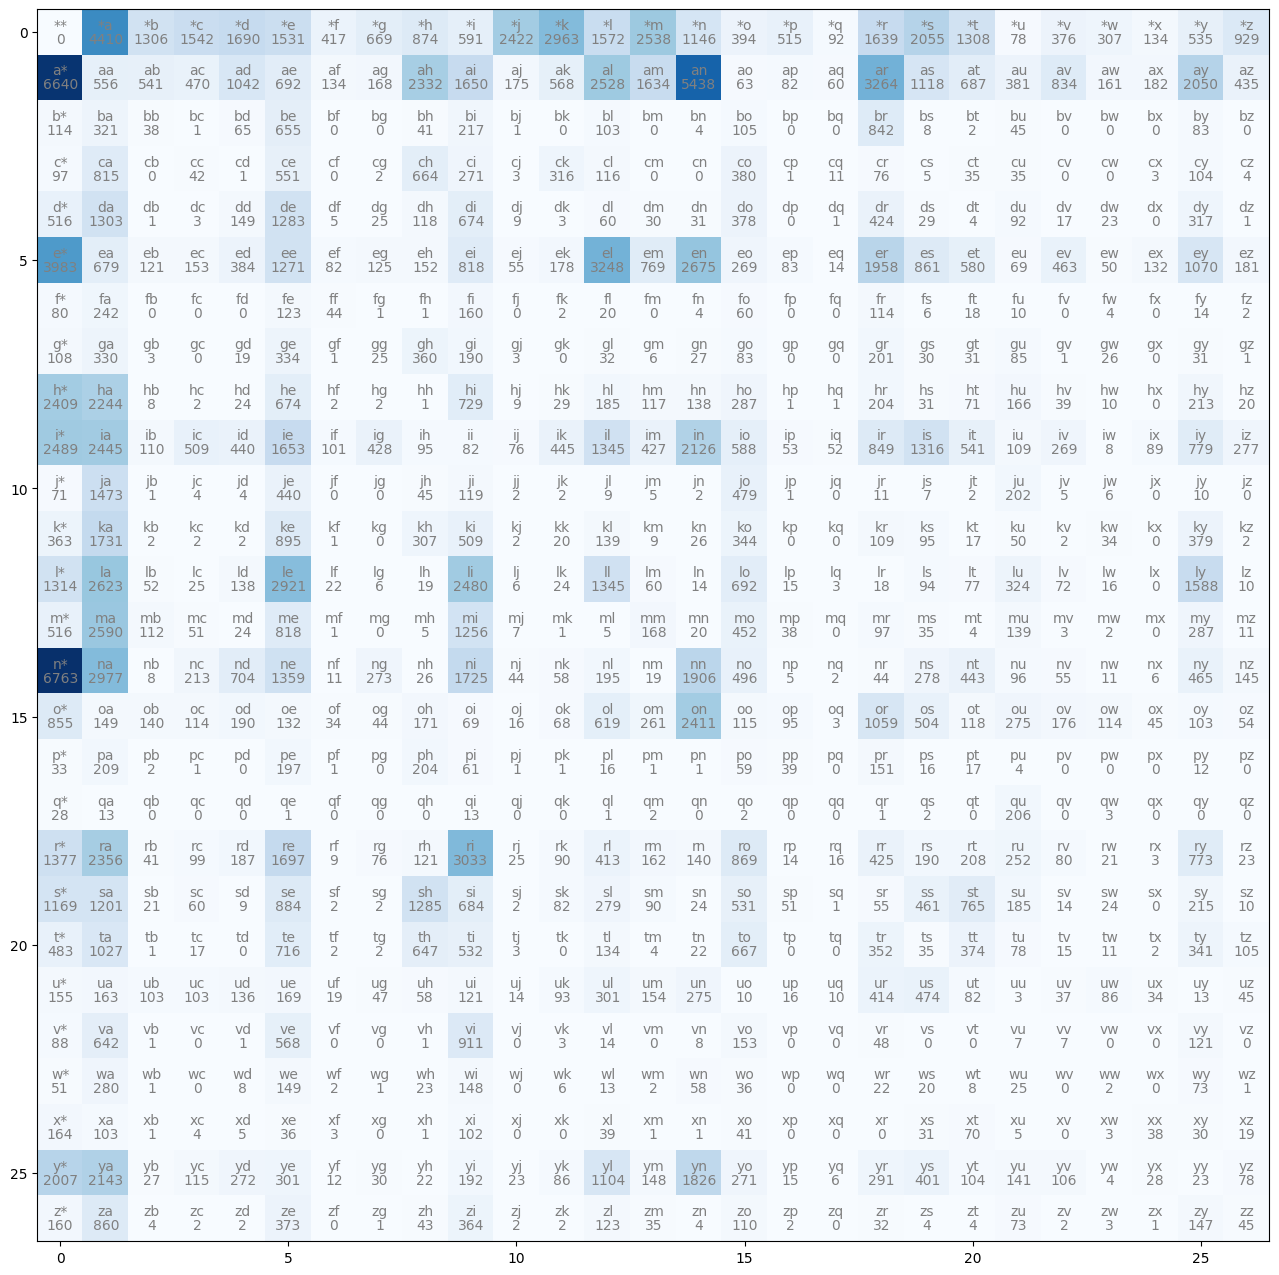

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
plt.imshow(bg_counts, cmap='Blues')
for i in range(len(vocab)):
    for j in range(len(vocab)):
        bgstr = itoc[i] + itoc[j]
        plt.text(j,i, bgstr, ha='center', va='bottom', color='gray')
        plt.text(j,i, bg_counts[i,j].item(), ha='center', va='top', color='gray')


#### We can have situations where a certain bi-gram may never occur in the corpus, in which case the count value will be zero. We can add a small "fake count" to all elements in the counts matrix to avoid having any zero counts. The larger the fake count value that we add, the smoother/more uniform the count distribution becomes. So this process of adding a fake count is also called "smoothing". 

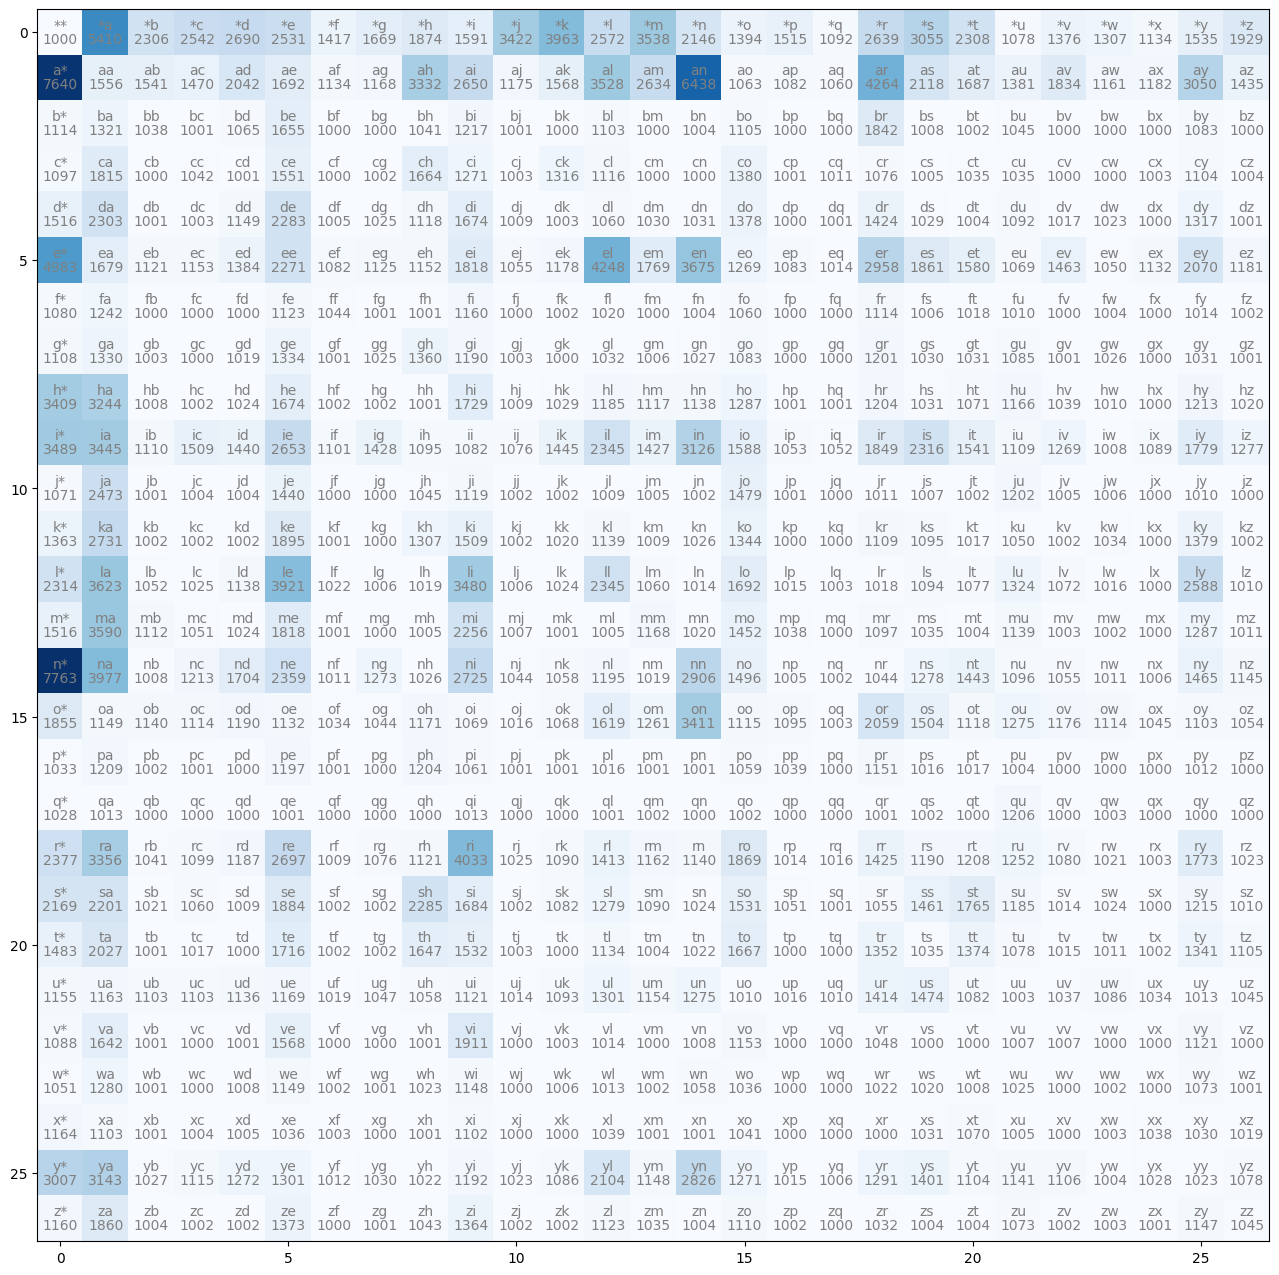

In [270]:
bg_counts_smooth = bg_counts + 1000

plt.figure(figsize=(16,16))
plt.imshow(bg_counts, cmap='Blues')
for i in range(len(vocab)):
    for j in range(len(vocab)):
        bgstr = itoc[i] + itoc[j]
        plt.text(j,i, bgstr, ha='center', va='bottom', color='gray')
        plt.text(j,i, bg_counts_smooth[i,j].item(), ha='center', va='top', color='gray')

In [269]:
# we can divide each row in our bigram counts array by the sum of all entries in thar row to get the desired bigram language model probability distribution: p(c2|c1) 
row_sum = torch.sum(bg_counts, dim=1, keepdim=True)
p = bg_counts.float() / row_sum.float()

# we can divide each row in our bigram counts array by the sum of all entries in thar row to get the desired bigram language model probability distribution: p(c2|c1) 
row_sum = torch.sum(bg_counts_smooth, dim=1, keepdim=True)
p_smooth = bg_counts_smooth.float() / row_sum.float()

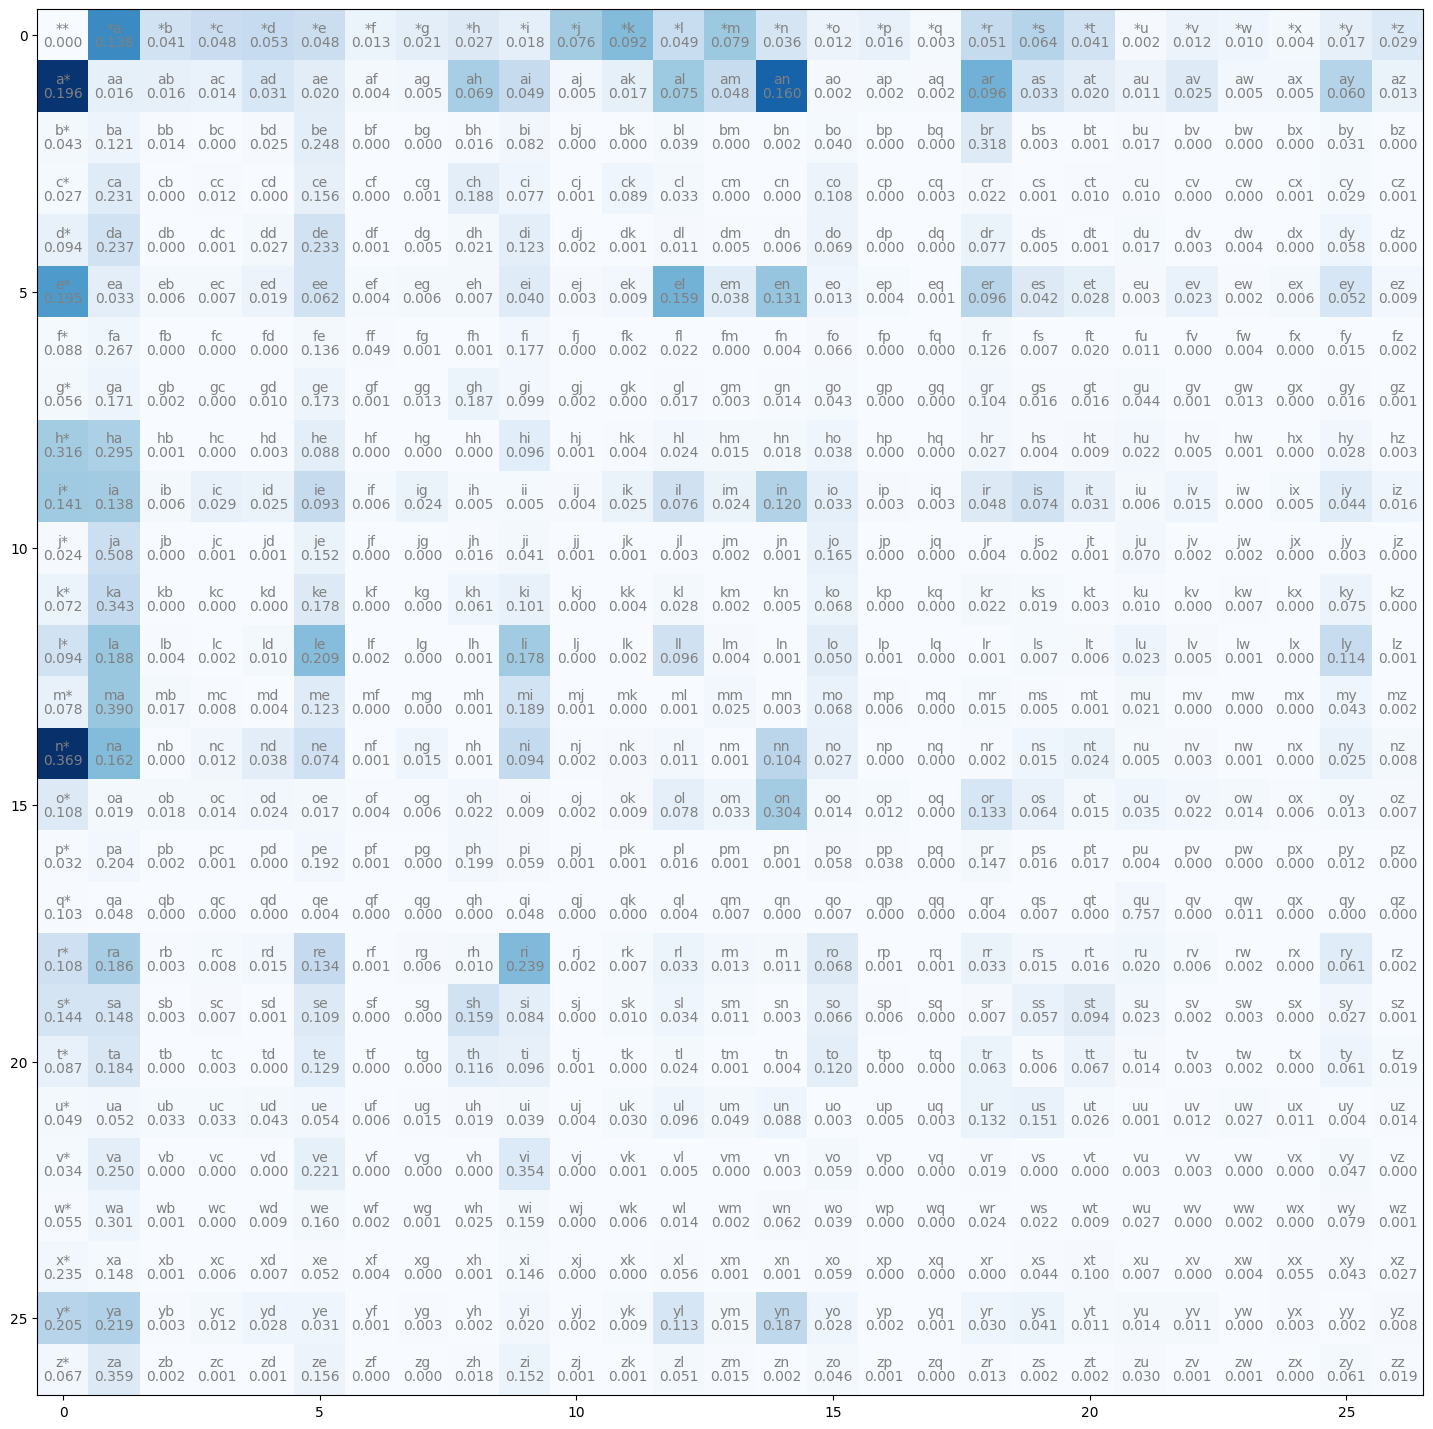

In [159]:
plt.figure(figsize=(18,18))
plt.imshow(bg_counts, cmap='Blues')
for i in range(len(vocab)):
    for j in range(len(vocab)):
        bgstr = itoc[i] + itoc[j]
        plt.text(j,i, bgstr, ha='center', va='bottom', color='gray')
        plt.text(j,i, f"{p[i,j].item():0.3f}", ha='center', va='top', color='gray')


### Now that we have the bi-gram  language model probabilty distribution, we can start generating new character sequences by sampling from this distribution  

In [160]:
# create a pytorch generator
g = torch.Generator().manual_seed(123)

def generate_word(start_char=None):

    generated_word = []
    end_ix = ctoi[special_token]

    # start with the special token
    if start_char is None:
        c1_ix = end_ix
    else:
        assert start_char in vocab, "Error! Start character must be a letter from the English alphabet."
        c1_ix = ctoi[start_char]
        generated_word.append(start_char)

    # generate characters one by one by sampling from the probability distribution p(c2|c1)
    while True:
        p21 = p[c1_ix]
        # sample the next character 
        c2_ix = torch.multinomial(p21, num_samples=1, replacement=True, generator=g).item()

        # stop if we generate the special token
        if c2_ix==end_ix:
            break
        
        c1_ix = c2_ix

        generated_word.append(itoc[c2_ix])

    return ''.join(generated_word) 

In [163]:
# generate a bunch of names
for i in range(20):
    print(generate_word())

meria
ch
aveneonoharen
tearenn
n
fam
nan
bellylugaylla
ve
kigosucynaynoppinostynn
za
e
m
th
ha
roe
angoedarmajouwustyn
jie
diesyx
kiazanle


### We can evaluate the quality of the model by estimating the likelihood of all the bigrams in the training corpus, or equivalently summing up the negative log probabilities of all bigrams in the training corpus, a.k.a negative log-likelihood loss. Lower the loss, higher the aulity of the model. We also normalize for the length of the corpus, i.e. divide by the total number of bigrams so that we get the average negative log likelihood.

In [271]:
negative_log_likelihood = 0.0
negative_log_likelihood_smooth = 0.0

n = 0
for w in words:
    # wrap the word with start and end special characters
    chars = [special_token] + list(w) + [special_token]
    # iterate over all bigrams
    for c1, c2 in zip(chars, chars[1:]):
        bigram = (c1,c2)
        ix1, ix2 = ctoi[c1], ctoi[c2]  
        negative_log_likelihood += torch.log(p[ix1, ix2]) 
        negative_log_likelihood_smooth += torch.log(p_smooth[ix1, ix2]) 
        n += 1

negative_log_likelihood = -negative_log_likelihood/n
negative_log_likelihood_smooth = -negative_log_likelihood_smooth/n

print(f"Log likelihood (averaged over all bigrams in corpus): {negative_log_likelihood}")
print(f"Log likelihood (averaged over all bigrams in corpus) with smoothing: {negative_log_likelihood_smooth}")

Log likelihood (averaged over all bigrams in corpus): 2.454094171524048
Log likelihood (averaged over all bigrams in corpus) with smoothing: 2.851738929748535


### We can see that the negative log likelihood loss is quite high indicating that the model is not doing a good job at prediciting the next character given the previous character from the training corpus. The best possible model will have zero loss. With smoothing applied to the counts, the loss is even higher.

### We will now train a simple neural network to learn the bigram probability distribution from the data.

In [184]:
import torch.nn.functional as F

# first create training data instances (x,y) which are bigram character pairs from the training corpus
xs, ys = [], []

for w in words:
    # wrap the word with start and end special characters
    chars = [special_token] + list(w) + [special_token]
    # iterate over all bigrams
    for c1, c2 in zip(chars, chars[1:]):
        ix1, ix2 = ctoi[c1], ctoi[c2]  
        xs.append(ix1)
        ys.append(ix2)

# create pytorch tensors of the inputs and targets
xs = torch.tensor(xs)        
ys = torch.tensor(ys)        

# we will use one hot encoding to encode each character as a one-hot vector of dimensions = vocab size
xenc = F.one_hot(xs, num_classes=len(vocab)).float()
yenc = F.one_hot(ys, num_classes=len(vocab)).float()

#### Our neural network will have a single input layer and a single output layer containing 27 neurons, each output neuron will represent the probability of predicting a corresponding character from the vocabulary as the target. (Note that this neural network has NO HIDDEN LAYERS, so basically our model is just a multi-class logistic regression classifier). These outputs probabilities are computed using the softmax function applied to a linear transform of the inputs. 

In [224]:
# define the parameters used for computing the output neurons 
W = torch.randn((len(vocab), len(vocab))) # parameters initialized randomly with values drawn from a normal distribution 

In [225]:
# compute logits, i.e. the linear transform of the inputs
logits = xenc @ W

In [226]:
# compute the softmax, applied to each row of the matrix of logits, this given us the predicted probability distribution for the target characters
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdims=True)

#### The logits can be interpreted as "log-counts" (hence the name "log-its"), then the exponentiated logits can be interpreted as counts, similar to how we counted up the bigrams and stored the counts in a matrix. Then taking the softmax is equivalent to normalizing these counts which gives us the desired probability distribution. 

In [235]:
# we can now compute the average negative log likelihood loss over all training instances
nnl = -prob[torch.arange(prob.size(0)), ys].log().mean()

In [272]:
# we can train our model by optimizing the weights
num_epochs = 1000
lr = 10.0 # gradient descent learning rate

W = torch.randn((len(vocab), len(vocab)), requires_grad=True) 

for i in range(num_epochs):

    # reset parameter gradients
    W.grad = None

    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    prob = counts / counts.sum(dim=1, keepdims=True)
    loss = -prob[torch.arange(prob.size(0)), ys].log().mean()

    # backward pass
    loss.backward()

    # update parameters via gradient descent
    W.data -= lr * W.grad

    if i % 10 == 0:
        print(f"Epoch# {i}, Average Loss: {loss.item()}")



Epoch# 0, Average Loss: 3.777060031890869
Epoch# 10, Average Loss: 3.1897692680358887
Epoch# 20, Average Loss: 2.941246509552002
Epoch# 30, Average Loss: 2.8129589557647705
Epoch# 40, Average Loss: 2.734163761138916
Epoch# 50, Average Loss: 2.6827480792999268
Epoch# 60, Average Loss: 2.647582530975342
Epoch# 70, Average Loss: 2.6222658157348633
Epoch# 80, Average Loss: 2.6031441688537598
Epoch# 90, Average Loss: 2.588085889816284
Epoch# 100, Average Loss: 2.575798273086548
Epoch# 110, Average Loss: 2.565483570098877
Epoch# 120, Average Loss: 2.556640625
Epoch# 130, Average Loss: 2.5489461421966553
Epoch# 140, Average Loss: 2.5421807765960693
Epoch# 150, Average Loss: 2.5361878871917725
Epoch# 160, Average Loss: 2.5308480262756348
Epoch# 170, Average Loss: 2.5260682106018066
Epoch# 180, Average Loss: 2.521771192550659
Epoch# 190, Average Loss: 2.517892837524414
Epoch# 200, Average Loss: 2.5143790245056152
Epoch# 210, Average Loss: 2.511183738708496
Epoch# 220, Average Loss: 2.5082674026

#### Note that this neural model's loss value converges to 2.45 which is the same loss value that we had for the bi-gram model! Also note that the weights matrix learned by the model converges to the counts matrix that we had for our bi-gram model (upto a rescaling factor).

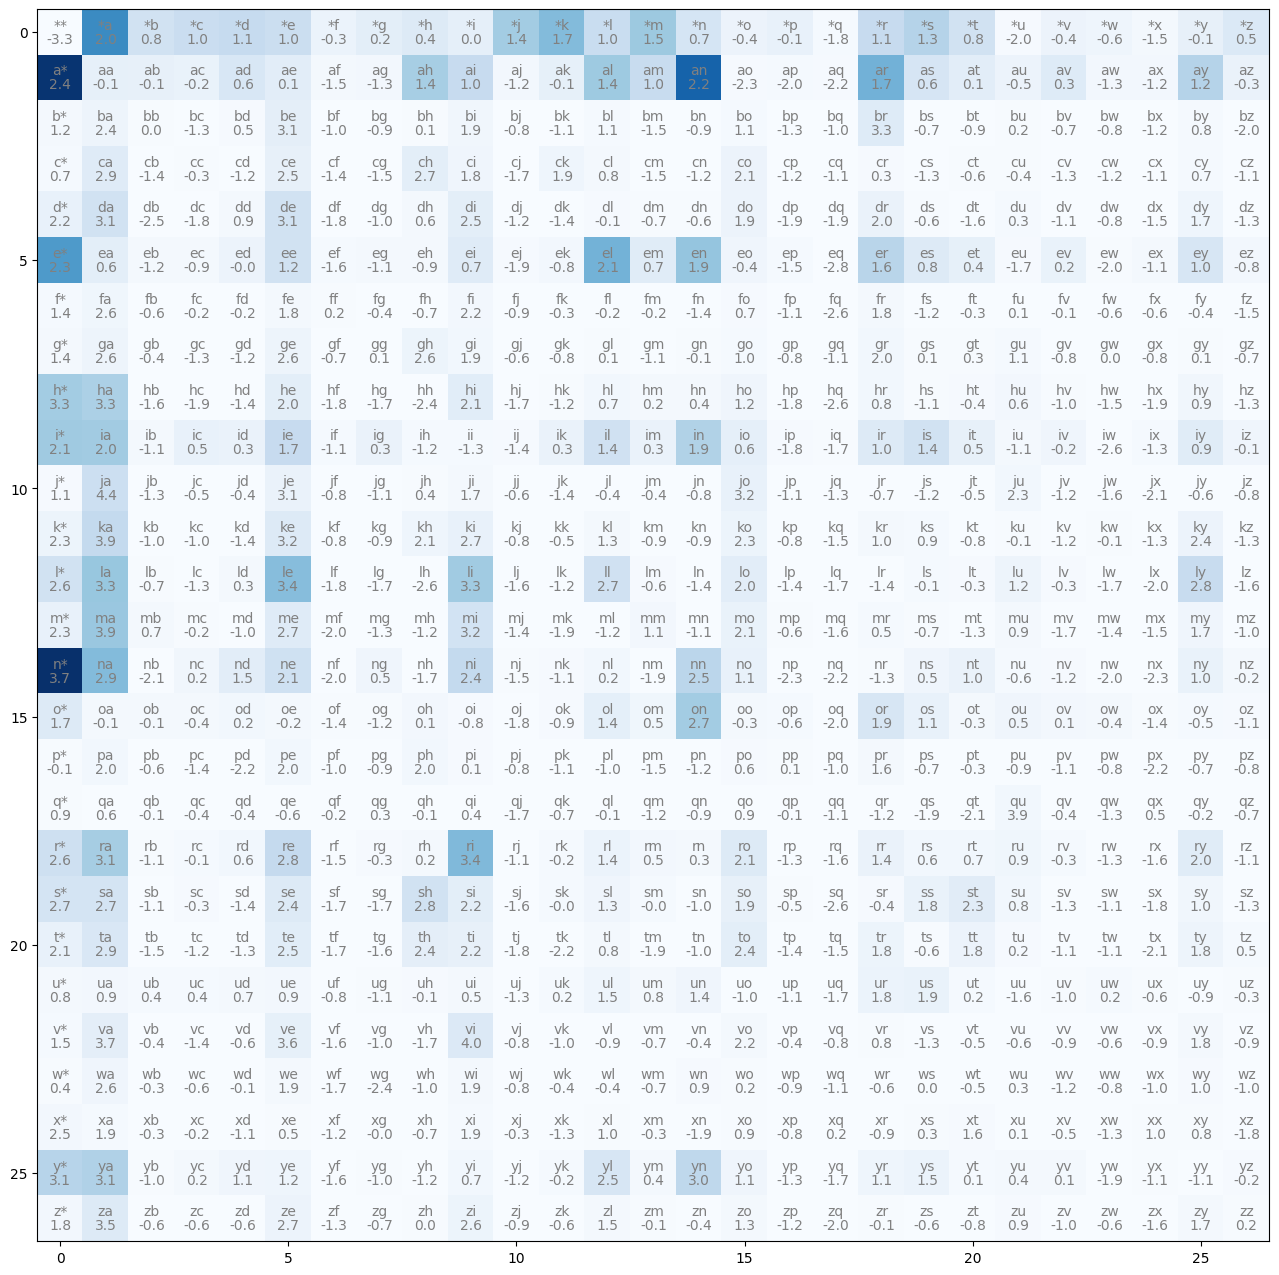

In [251]:
plt.figure(figsize=(16,16))
plt.imshow(bg_counts, cmap='Blues')
for i in range(len(vocab)):
    for j in range(len(vocab)):
        bgstr = itoc[i] + itoc[j]
        plt.text(j,i, bgstr, ha='center', va='bottom', color='gray')
        plt.text(j,i, f"{W[i,j].item():.1f}", ha='center', va='top', color='gray')

#### Now lets try sampling from this neural network model

In [277]:
# create a pytorch generator
g = torch.Generator().manual_seed(123)

def generate_word_nn(start_char=None):

    generated_word = []
    end_ix = ctoi[special_token]

    # start with the special token
    if start_char is None:
        c1_ix = end_ix
    else:
        assert start_char in vocab, "Error! Start character must be a letter from the English alphabet."
        c1_ix = ctoi[start_char]
        generated_word.append(start_char)

    # generate characters one by one by sampling from the probability distribution p(c2|c1)
    while True:
        # get probabilities from the neural network
        logits = W[c1_ix,:]
        counts = logits.exp()
        p21 = counts / counts.sum()
        
        # sample the next character 
        c2_ix = torch.multinomial(p21, num_samples=1, replacement=True, generator=g).item()

        # stop if we generate the special token
        if c2_ix==end_ix:
            break
        
        c1_ix = c2_ix

        generated_word.append(itoc[c2_ix])

    return ''.join(generated_word) 

In [278]:
# generate a bunch of names
for i in range(20):
    print(generate_word_nn())

ldlyahahi
icaton
moresan
dya
coke
ssana
ry
nahikneeyzatan
mele
k
n
a
hrusinarichrncen
bte
ma
kacynida
myn
joevar
me
jai


#### Note that this neural network model generates very similar names as the bi-gram model.

#### For our bi-gram model, we had the option of adding a fake count to our counts matrix to acheive a smoothing effect. We can acheive a similar smoothing effect which makes the weights matrix more uniform by adding an l2 regularization term to the loss which drives all the weights to be close to zero.

In [258]:
# we can train our model by optimizing the weights
num_epochs = 1000
lr = 10.0     # gradient descent learning rate
alpha = 1.0  # reguarization strength

W = torch.randn((len(vocab), len(vocab)), requires_grad=True) 

for i in range(num_epochs):

    # reset parameter gradients
    W.grad = None

    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    prob = counts / counts.sum(dim=1, keepdims=True)
    loss = -prob[torch.arange(prob.size(0)), ys].log().mean() + alpha * (W**2).mean()

    # backward pass
    loss.backward()

    # update parameters via gradient descent
    W.data -= lr * W.grad

    if i % 10 == 0:
        print(f"Epoch# {i}, Average Loss: {loss.item()}")


Epoch# 0, Average Loss: 4.626226425170898
Epoch# 10, Average Loss: 3.573915481567383
Epoch# 20, Average Loss: 3.197687864303589
Epoch# 30, Average Loss: 3.0361392498016357
Epoch# 40, Average Loss: 2.9622817039489746
Epoch# 50, Average Loss: 2.9271481037139893
Epoch# 60, Average Loss: 2.9099037647247314
Epoch# 70, Average Loss: 2.901242733001709
Epoch# 80, Average Loss: 2.8968210220336914
Epoch# 90, Average Loss: 2.894535779953003
Epoch# 100, Average Loss: 2.893343687057495
Epoch# 110, Average Loss: 2.8927173614501953
Epoch# 120, Average Loss: 2.892385482788086
Epoch# 130, Average Loss: 2.89220929145813
Epoch# 140, Average Loss: 2.8921146392822266
Epoch# 150, Average Loss: 2.892064094543457
Epoch# 160, Average Loss: 2.8920364379882812
Epoch# 170, Average Loss: 2.892021894454956
Epoch# 180, Average Loss: 2.8920137882232666
Epoch# 190, Average Loss: 2.8920094966888428
Epoch# 200, Average Loss: 2.8920071125030518
Epoch# 210, Average Loss: 2.8920059204101562
Epoch# 220, Average Loss: 2.8920

#### When the regularization strength is very high, the smoothing effect becomes significant and we end up with higher loss value, similar to what we saw when we applied smoothing to the bi-gram model counts. 

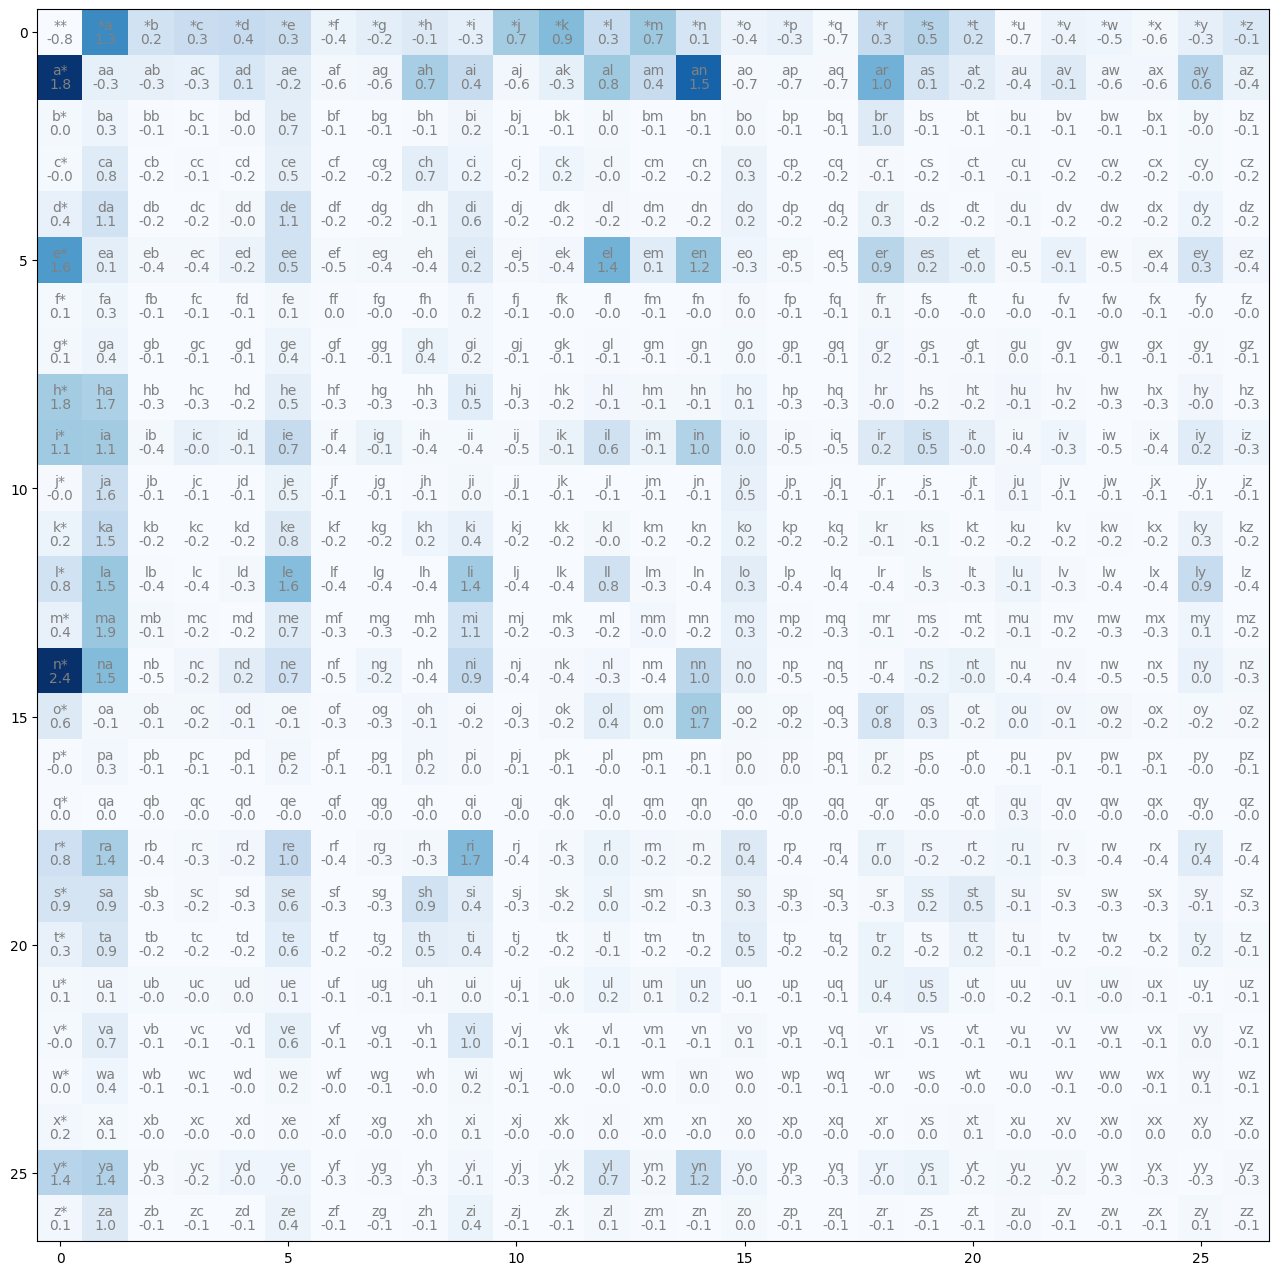

In [259]:
plt.figure(figsize=(16,16))
plt.imshow(bg_counts, cmap='Blues')
for i in range(len(vocab)):
    for j in range(len(vocab)):
        bgstr = itoc[i] + itoc[j]
        plt.text(j,i, bgstr, ha='center', va='bottom', color='gray')
        plt.text(j,i, f"{W[i,j].item():.1f}", ha='center', va='top', color='gray')